#### Import modules

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import pickle

Read state codes mapping file:

In [2]:
name_to_code = []

with open(os.getcwd() + '/Data/name_to_code.pickle', 'rb') as pckl:
    name_to_code = pickle.load(pckl)
    
pckl.close()

name_to_code['Massachusetts']

'MA'

### States

#### Read data file

In [3]:
states_cases = pd.read_csv(os.getcwd() + '/Data/us-states.csv')
states_cases.shape

(33494, 5)

In [4]:
states_cases.tail()

,date,state,fips,cases,deaths
33489,2021-10-31,Virginia,51,924771,13907
33490,2021-10-31,Washington,53,727820,8686
33491,2021-10-31,West Virginia,54,272532,4426
33492,2021-10-31,Wisconsin,55,882618,9416
33493,2021-10-31,Wyoming,56,102926,1174


In [5]:
# pd.Series(states_cases['state'].unique()).sort_values()
states_cases['state'].unique().shape

(56,)

#### Preprocess data

Remove AK, HI, and territories, and label DC:

In [6]:
states_cases['state_code'] = states_cases['state'].apply(lambda x: name_to_code[x] if x in name_to_code else 'EXCLUDE')
states_cases.loc[states_cases['state'] == 'District of Columbia', 'state_code'] = 'DC'
states_cases.loc[(states_cases['state_code'] == 'HI') | (states_cases['state_code'] == 'AK'), 'state_code'] = 'EXCLUDE'

states_cases.tail()

,date,state,fips,cases,deaths,state_code
33489,2021-10-31,Virginia,51,924771,13907,VA
33490,2021-10-31,Washington,53,727820,8686,WA
33491,2021-10-31,West Virginia,54,272532,4426,WV
33492,2021-10-31,Wisconsin,55,882618,9416,WI
33493,2021-10-31,Wyoming,56,102926,1174,WY


In [7]:
states_cases[states_cases['state_code'] == 'EXCLUDE']['state'].unique()

array(['Hawaii', 'Alaska', 'Puerto Rico', 'Virgin Islands', 'Guam',
       'Northern Mariana Islands', 'American Samoa'], dtype=object)

In [8]:
states_cases = states_cases[states_cases['state_code'] != 'EXCLUDE']
states_cases['state'].unique().shape

(49,)

Convert date from string to date type:

In [9]:
states_cases['date'] = pd.to_datetime(states_cases['date'])

Sample pipeline to get daily cases:

(need to figure out if this works for all data)

In [10]:
small_df = states_cases[states_cases['date'] > '2021-10-20'].copy()

small_df.sort_values(['state_code', 'date'], inplace = True)

small_df['new_cases'] = small_df.groupby(['state_code'])['cases'].transform(lambda x: x.diff())

small_df

,date,state,fips,cases,deaths,state_code,new_cases
32878,2021-10-21,Alabama,1,817054,15320,AL,NaN
32934,2021-10-22,Alabama,1,818652,15378,AL,1598.0
32990,2021-10-23,Alabama,1,819597,15406,AL,945.0
33046,2021-10-24,Alabama,1,820011,15407,AL,414.0
33102,2021-10-25,Alabama,1,820312,15407,AL,301.0
...,...,...,...,...,...,...,...
33269,2021-10-27,Wyoming,56,101912,1174,WY,488.0
33325,2021-10-28,Wyoming,56,102403,1174,WY,491.0
33381,2021-10-29,Wyoming,56,102926,1174,WY,523.0
33437,2021-10-30,Wyoming,56,102926,1174,WY,0.0


In [30]:
small_df_corrs = small_df.pivot(index = 'date', columns = 'state_code', values = 'new_cases').corr()
small_df_corrs.head()

state_code,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
state_code,,,,,,,,,,,,,,,,,,,,,
AL,1.000000,0.443081,0.746875,0.119944,0.126350,0.108660,-0.007688,-0.039669,0.099996,0.399152,...,0.356948,0.210119,0.281991,0.262543,0.142034,-0.109386,0.107929,0.167119,0.549429,0.224966
AR,0.443081,1.000000,0.551349,0.483710,-0.012464,0.001919,-0.128191,0.230553,0.090242,0.155411,...,0.490840,0.561738,0.584977,0.065402,-0.051697,-0.046367,-0.005504,0.141461,0.657850,0.114270
AZ,0.746875,0.551349,1.000000,-0.208232,-0.218823,-0.206025,-0.256853,0.369840,-0.233540,-0.011865,...,-0.033997,-0.115152,-0.033540,-0.133306,-0.226712,0.217088,-0.258291,-0.233253,0.568213,-0.099803
CA,0.119944,0.483710,-0.208232,1.000000,0.447814,0.335012,0.197812,-0.552556,0.390211,0.417100,...,0.848575,0.945160,0.804489,0.436713,0.319136,-0.199968,0.430965,0.594980,0.112584,0.402675
CO,0.126350,-0.012464,-0.218823,0.447814,1.000000,0.973711,0.946002,-0.267061,0.850845,0.930112,...,0.581241,0.274737,0.678592,0.962240,0.954506,-0.102484,0.989729,0.945130,0.416511,0.966193


In [36]:
edge_list = []

for state in small_df_corrs.columns:
    for neighbour in small_df_corrs[state][small_df_corrs[state] > 0.5].index:
        if state != neighbour and (neighbour, state) not in edge_list:
            edge_list.append((state, neighbour))
            
len(edge_list)

561

In [37]:
corr_g = nx.Graph()
corr_g.add_edges_from(edge_list)

nx.info(corr_g)

'Graph with 49 nodes and 561 edges'

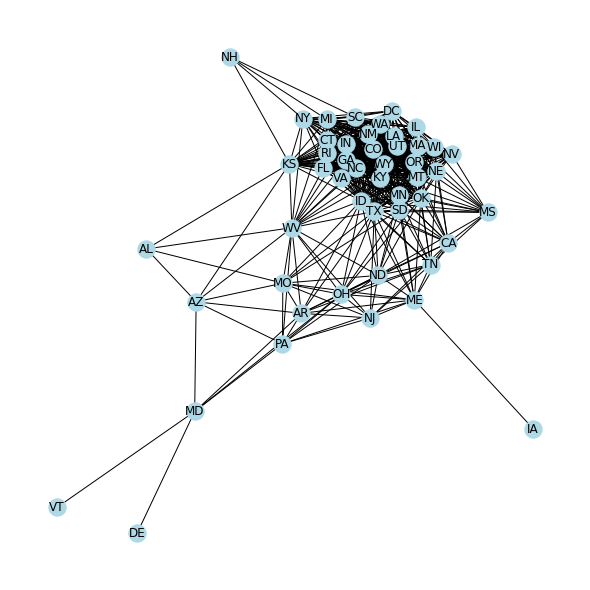

In [38]:
fig = plt.figure(figsize = (8, 8))
nx.draw(corr_g, node_color = '#add8e6', with_labels = True)
plt.show()
plt.close()